In [76]:
import subprocess
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import defaultdict
import matplotlib.gridspec as gridspec
import string
import math
from io import StringIO
import subprocess
import numpy as np
from matplotlib.lines import Line2D

alphabet = list(string.ascii_lowercase)

In [132]:
def query_db(query, args=''):
    cmd = "mysql {} -e \"{}\"".format(args, query)
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if p.returncode > 0:
        print("Failed to query database with error:")
        print(p.stderr.decode())
    else:
        df = pd.read_csv(StringIO(p.stdout.decode()), sep='\t')
        return df
    
p1 = re.compile(r'(\w+)\/(\w+\_end)\/((E|D|S)RR[0-9]{6,})')
p4 = re.compile(r'(\w+)\/((E|D|S)RR[0-9]{6,})')
p2 = re.compile(r'(.+\))\:\s(.+)')
p3 = re.compile(r'signal\s(\d+)')

def conv_KB_to_MB(input_kilobyte):
    # FROM https://stackoverflow.com/questions/39284008/how-to-convert-mb-to-gb-with-precision-in-python
    megabyte = 1./1000
    convert_mb = megabyte * input_kilobyte
    return convert_mb

def conv_MB_to_GB(input_megabyte):
    # FROM https://stackoverflow.com/questions/39284008/how-to-convert-mb-to-gb-with-precision-in-python 
    gigabyte = 1.0/1024
    convert_gb = gigabyte * input_megabyte
    return convert_gb

def parse_time(fname):
    
    d = defaultdict(dict)
    
    with open(fname, 'r') as f:
        for l in f.readlines():
            l = l.strip()
            if l.startswith('==>'):
                m = p1.findall(l)
                if len(m) > 0:
                    rule, read_type, accession, _ = m[0]
                else:
                    read_type = pd.NA
                    m = p4.findall(l)
                    try:
                        rule, accession, _ = m[0]
                    except: 
                        rule, accession = l.split(' ')[1], l.split(' ')[1]

                d[rule][accession] = {'read_type': read_type}

            elif 'terminated' in l:
                d[rule][accession]['terminated_signal'] = int(p3.findall(l)[0])
            elif ':' in l:
                ls = l.split(':')
                if len(ls) == 2:
                    try:
                        d[rule][accession][ls[0]] = float(ls[1])
                    except:
                        d[rule][accession][ls[0]] = ls[1]
                else:
                    m = p2.findall(l)
                    d[rule][accession][m[0][0]] = m[0][1]

    df = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()},
                       orient='index')
    df.index.names = ['rule', 'sample']
    df['file'] = fname

    if 'terminated_signal' in df.columns:
        df['terminated_signal'].fillna(0, inplace=True)
        
    
    # create cpu time measurements
    df['cpu_time_s'] =df['User time (seconds)'] + df['System time (seconds)']
    df['cpu_time_h'] =df['cpu_time_s'] / 3600
    
    df['tool'] = df['Command being timed'].apply(lambda x: x.split(' ')[1].replace('"', '') if isinstance(x, str) else pd.NA)
    
    # where bbduk is the tool find out whether output was zipped or not
    df.loc[
        df['tool'] == 'bbduk.sh', 'tool'
    ] = df.loc[
        df['tool'] == 'bbduk.sh', 'Command being timed'
    ].str.count('gz').isin([2,4]).apply(
        lambda x: 'bbduk.sh zipped' if x else 'bbduk.sh'
    )
    
    #kbytes to gigabytes
    df['Maximum resident set size (mb)'] = df['Maximum resident set size (kbytes)'].apply(conv_KB_to_MB)
    df['Maximum resident set size (gb)'] = df['Maximum resident set size (mb)'].apply(conv_MB_to_GB)

    return df.reset_index()

def figure_saver(fig, prefix, contexts=['paper'], formats=['.png', '.pdf', '.tiff']):
    
    for context in contexts:
        
        for fformat in formats:
            fname = f"{prefix}_{context}{fformat}"
            fig.savefig(fname,  bbox_inches = "tight")
    
    sns.set_context('paper')

def get_cmap(labels, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    cmap = plt.get_cmap(name, len(labels))#.colors
    
    return {l: cmap(i) for i, l in enumerate(labels)}

In [3]:
dfs = {
    'zip': parse_time('data/AvA_benchmarking.times'),
    'final': parse_time('data/AvA_benchmarking_final.times'),
}

In [4]:
samples29 = [
    'ERR056997', 'ERR1135612', 'ERR1884262','ERR209998',
    'ERR2239761', 'ERR262503', 'ERR2764819', 'ERR299538',
    'ERR3213717', 'ERR3593315', 'ERR3641954', 'SRR10154308',
    'SRR10158848', 'SRR1027651', 'SRR1044677', 'SRR1179181',
    'SRR1524512', 'SRR2094831', 'SRR2237446', 'SRR3434587',
    'SRR3989182', 'SRR4929941', 'SRR5950773', 'SRR6401741',
    'SRR7125621', 'SRR7533096', 'SRR7992574', 'SRR7992575',
    'SRR9178241',
]



# Where do the samples lay in comparison to the others included in the 214K collection?

Data can be retrieved from Zenodo https://zenodo.org/record/7553776/files/diversity.tsv?download=1

In [5]:
argDiv = query_db("use AvA; select run_accession, total_fragments, category_fragments from Diversity where category='ARG'")
argDiv['Selected'] = argDiv.run_accession.isin(samples29)

In [6]:
argDiv.head()

,run_accession,total_fragments,category_fragments,Selected
0,DRR000836,1247751,6.69250,False
1,DRR000980,1190673,20.65900,False
2,DRR000981,792888,14.04850,False
3,DRR001355,102043,9.80714,False
4,DRR001356,178504,51.09450,False


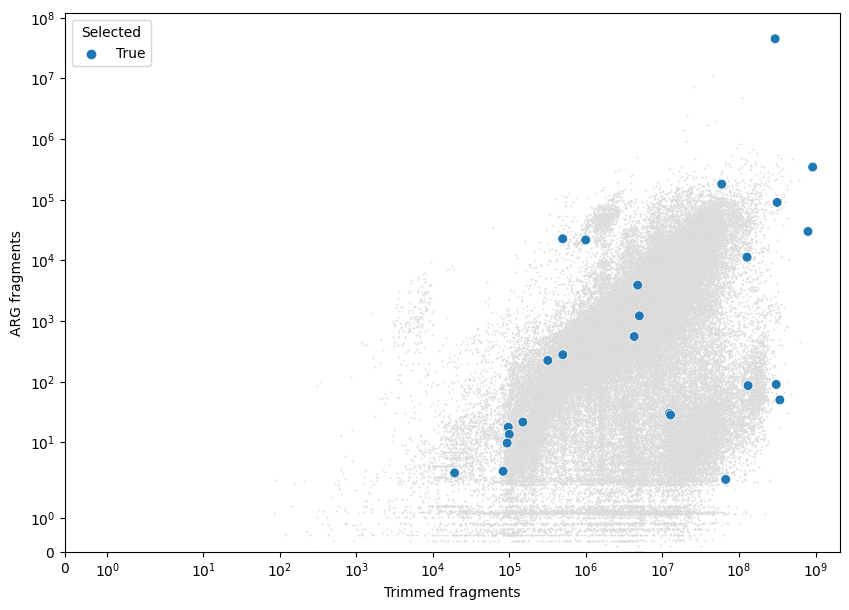

In [7]:
fig, ax = plt.subplots(figsize=(10,7))

sns.scatterplot(
    data = argDiv.query("Selected == False"),
    x = 'total_fragments',
    y = 'category_fragments',
    color='lightgrey',
    s=2,
    alpha = .75,
)

sns.scatterplot(
    data = argDiv.query("Selected == True"),
    x = 'total_fragments',
    y = 'category_fragments',
    hue = 'Selected',
    palette=get_cmap(labels=[True], name='tab10'),
    s=50,
    alpha = 1,
)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_xlim(0, ax.get_xlim()[-1])
ax.set_ylim(0, ax.get_ylim()[-1])
ax.set_xlabel('Trimmed fragments')
ax.set_ylabel('ARG fragments')
figure_saver(fig=fig, prefix='figures/selected_benchmark_samples')

# Download times

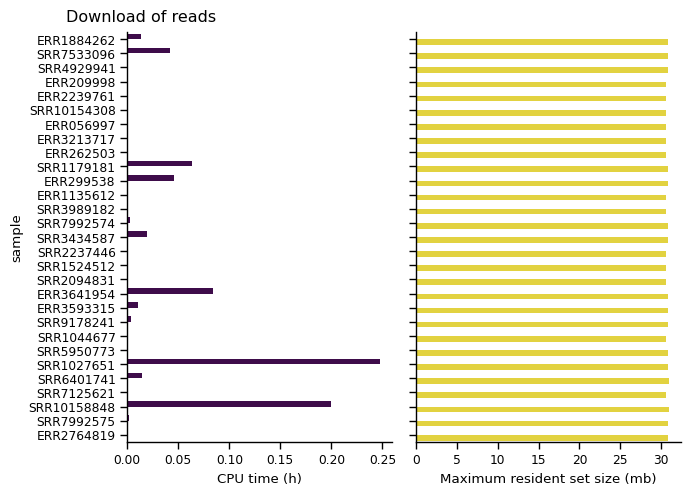

In [8]:
Palette = get_cmap(labels=['cpu_time_h', 'Maximum resident set size (mb)'])

g = sns.catplot(
    data = dfs['zip'].query("rule == 'raw_reads' & sample in @samples29").melt(id_vars=['sample'], value_vars=['cpu_time_h', 'Maximum resident set size (mb)']),
    x = 'value',
    y = 'sample',
    hue = 'variable',
    col = 'variable',
    kind='bar',
    sharex=False,
    palette=Palette,
    aspect=.7
)
g.set_titles("")
xlabels = ['CPU time (h)', 'Maximum resident set size (mb)']
for ax, xlabel in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xlabel)

g.fig.suptitle('Download of reads', horizontalalignment='left', x=0.1)
figure_saver(fig=g.fig, prefix='figures/download_times')

# Comparing times for trimming of reads

A comparison between bbduk.sh with zipping of output, bbduk.sh without zipping of output, and fastp.

In [9]:
trimTimes = pd.concat(
    [
        dfs['zip'].query("sample in @samples29 & rule  in ('trimmed_reads', 'trimmed_reads_unzipped')"), 
        dfs['final'].query("sample in @samples29 & rule == 'trimmed_reads'").replace('trimmed_reads', 'fastp'),

    ]
)

trimTimesP = trimTimes.pivot_table(index=['sample', 'rule'], values=['cpu_time_h', 'Maximum resident set size (mb)', 'Maximum resident set size (gb)']).reset_index()

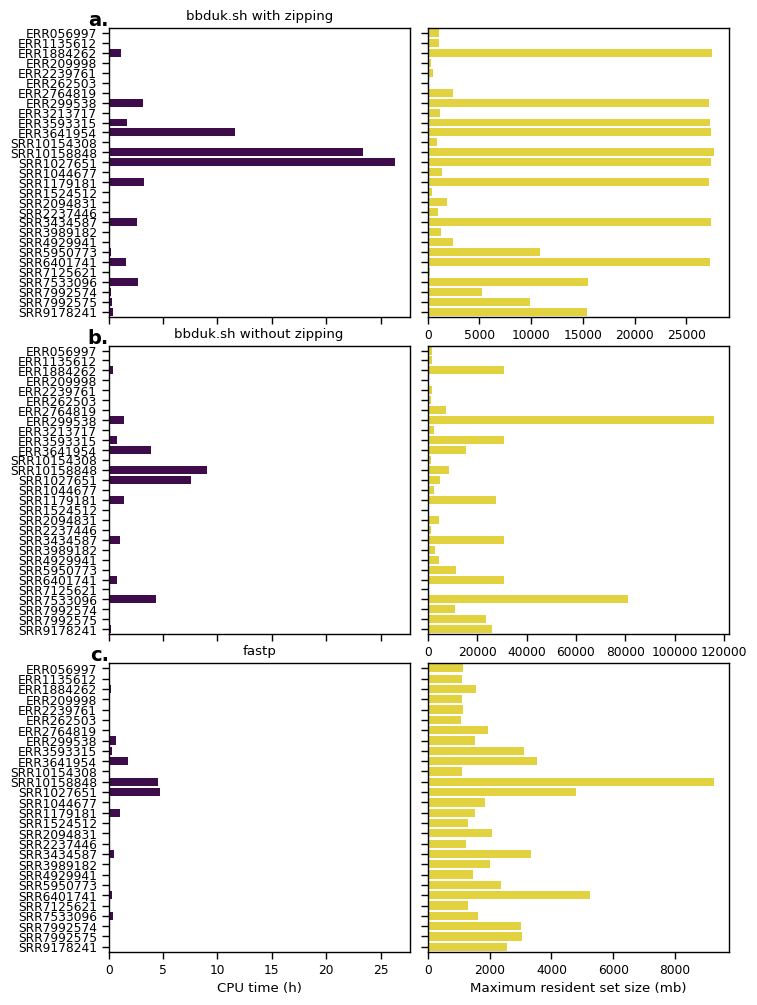

In [10]:
gs = gridspec.GridSpec(ncols=2, nrows=3, hspace=0.1, wspace=0.06)
fig = plt.figure(figsize=(8,12))

#ax_host_b = fig.add_subplot(gs[0, 1], sharey=ax_host)
ax_bbdukz_h = fig.add_subplot(gs[0,0])
ax_bbdukz_m = fig.add_subplot(gs[0, 1], sharey=ax_bbdukz_h)

ax_bbduk_h = fig.add_subplot(gs[1,0], sharex=ax_bbdukz_h)
ax_bbduk_m  = fig.add_subplot(gs[1,1], sharey=ax_bbduk_h)

ax_fastp_h = fig.add_subplot(gs[2,0], sharex=ax_bbdukz_h)
ax_fastp_m = fig.add_subplot(gs[2,1], sharey=ax_fastp_h)

x1 = 'cpu_time_h'
x2 = 'Maximum resident set size (mb)'

trimPalette = get_cmap(labels=[x1, x2])

# plot 
sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads'"),
    x = x1,
    y = 'sample',
    color=trimPalette[x1],
    ax = ax_bbdukz_h
)

sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads'"),
    x = x2,
    y = 'sample',
    color=trimPalette[x2],
    ax = ax_bbdukz_m
)


sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads_unzipped'"),
    x = x1,
    y = 'sample',
    color=trimPalette[x1],
    ax = ax_bbduk_h
)

sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads_unzipped'"),
    x = x2,
    y = 'sample',
    color=trimPalette[x2],
    ax = ax_bbduk_m
)

sns.barplot(
    data = trimTimesP.query("rule == 'fastp'"),
    x = x1,
    y = 'sample',
    color=trimPalette[x1],
    ax = ax_fastp_h
)

sns.barplot(
    data = trimTimesP.query("rule == 'fastp'"),
    x = x2,
    y = 'sample',
    color=trimPalette[x2],
    ax = ax_fastp_m
)

    
for i, (ax, title) in enumerate(zip([ax_bbdukz_h, ax_bbduk_h, ax_fastp_h], ['bbduk.sh with zipping', 'bbduk.sh without zipping', 'fastp'])):
    # -0.05, 1.05,
    ax.text(-0.0, 1.06, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    ax.set_title(title)
    ax.set_ylabel('')
    
    if i < 2:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel('')
    else:
        ax.set_xlabel('CPU time (h)')
        
    
for i, ax in enumerate([ax_bbdukz_m, ax_bbduk_m, ax_fastp_m]):
    ax.set_ylabel('')
    ax.tick_params(labelleft=False)
    
    if i < 2:
        #ax.tick_params(labelbottom=False)
        ax.set_xlabel('')
        plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
        
figure_saver(fig=fig, prefix='figures/trim_comparisons')

# Using KMA for mapping and alignment of reads

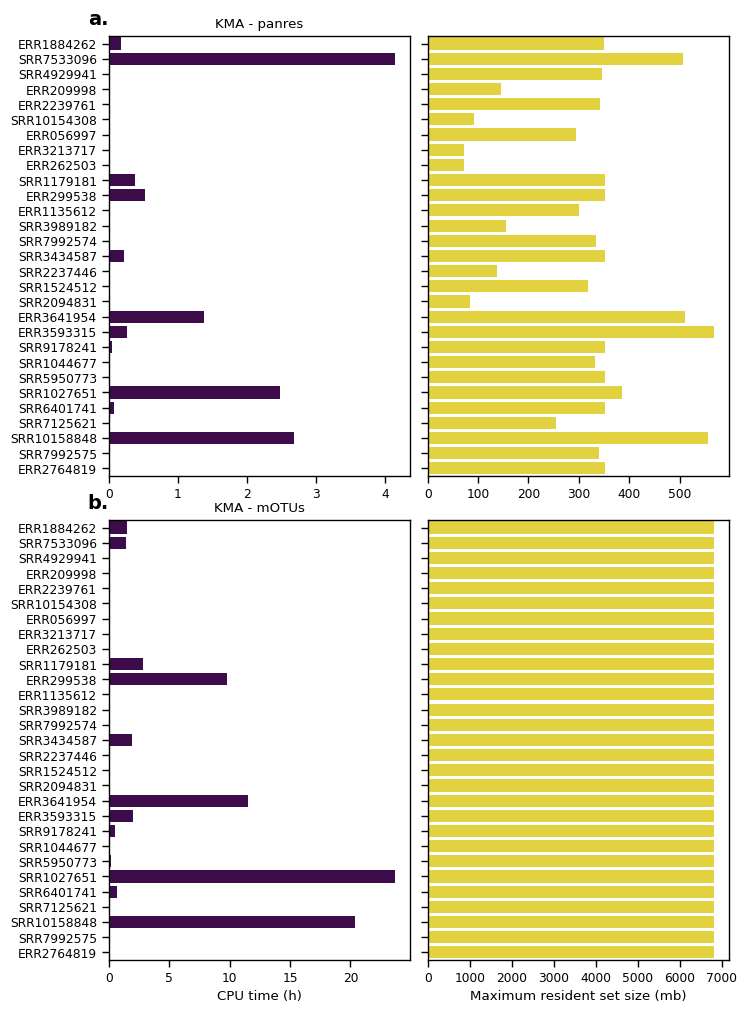

In [12]:
rules = ['kma_panres', 'kma_mOTUs']
columns = ['cpu_time_h', 'Maximum resident set size (mb)']
collabels = {'cpu_time_h': 'CPU time (h)', 'Maximum resident set size (mb)': 'Maximum resident set size (mb)'}

gs = gridspec.GridSpec(ncols=len(columns), nrows=len(rules), hspace=0.1, wspace=0.06,)
fig = plt.figure(figsize=(8,12))

axes = defaultdict(dict)
for i, rule in enumerate(rules):
    for j, col in enumerate(columns):
        if i == 0:
            ax = fig.add_subplot(gs[i, j])
        elif i > 0 and j == 0:
            ax = fig.add_subplot(gs[i,j])#, sharex=axes[i-1][j])
        else:
            ax = fig.add_subplot(gs[i,j],sharey=axes[i][j-1]) # sharex=axes[i-1][j])
        
        axes[i][j] = ax
        
        sns.barplot(
            data = dfs['final'].query(f"rule == @rule & sample in @samples29").dropna(subset=col),
            x = col,
            y = 'sample',
            color = trimPalette[col],
            ax = ax
        )
        
        if i == 0:
            ax.set_xlabel('')
            plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
        elif i+1 == len(rules):
            ax.set_xlabel(collabels[col])
        
        ruleTitle = f"KMA - {rule.split('_')[-1]}"
        
        if j == 0:
            ax.set_title(ruleTitle)
            ax.set_ylabel('')
            ax.text(-0.0, 1.06, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        elif j == 1:
            ax.set_ylabel('')
            plt.setp(ax.get_yaxis().get_ticklabels(), visible=False)
            
figure_saver(fig=fig, prefix='figures/kma_comparisons')

# Mash

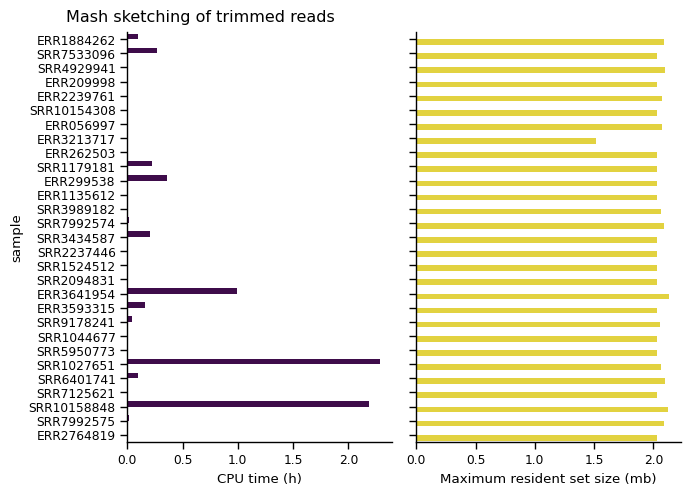

In [13]:
g = sns.catplot(
    data = dfs['final'].query(f"rule == 'mash_sketch'").melt(id_vars=['sample'], value_vars=['cpu_time_h', 'Maximum resident set size (mb)']),
    x = 'value',
    y = 'sample',
    col = 'variable',
    hue = 'variable',
    palette = Palette,
    sharex=False,
    kind='bar',
    aspect = .7
)
g.set_titles("")
xlabels = ['CPU time (h)', 'Maximum resident set size (mb)']
for ax, xlabel in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xlabel)
    
g.fig.suptitle('Mash sketching of trimmed reads', horizontalalignment='left', x=0.1)
figure_saver(fig=g.fig, prefix='figures/mash_comparisons')

# ARGextender
also called seed_extender in these files

In [96]:
dat = dfs['final'].query("rule == 'seed_extender'").copy()
dat['status'] = dat['Exit status'] == 0
dat.loc[dat['Exit status'].isna(), 'cpu_time_h'] = 48

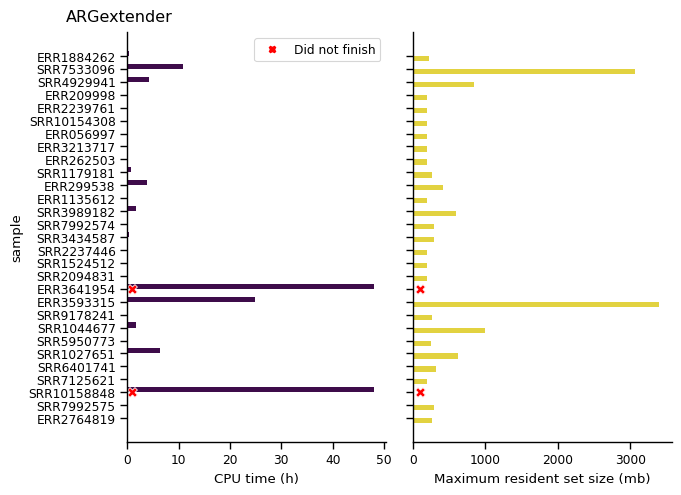

In [216]:
g = sns.catplot(
    data = dat.melt(id_vars=['sample'], value_vars=['cpu_time_h', 'Maximum resident set size (mb)']),
    x = 'value',
    y = 'sample',
    col = 'variable',
    hue = 'variable',
    palette = Palette,
    sharex=False,
    kind='bar',
    aspect = .7
)

sns.scatterplot(
    y = dat.query("status == False")['sample'].map({t.get_text(): i for i, t in enumerate(g.axes[0][0].get_yticklabels())}).values,
    x = [1,1],
    ax = g.axes[0][0],
    marker='X',
    color = 'red',
    s = 50,
)

sns.scatterplot(
    y = dat.query("status == False")['sample'].map({t.get_text(): i for i, t in enumerate(g.axes[0][0].get_yticklabels())}).values,
    x = [100,100],
    ax = g.axes[0][1],
    marker='X',
    color = 'red',
    s = 50,
    
)

g.set_titles("")
xlabels = ['CPU time (h)', 'Maximum resident set size (mb)']
for ax, xlabel in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xlabel)
    ax.get_legend().remove()
    
g.axes[0][0].legend(loc='upper right', handles=[Line2D([0],[0], color='red', marker='X', linestyle='', label='Did not finish')]) 
    
g.fig.suptitle('ARGextender', horizontalalignment='left', x=0.1)
figure_saver(fig=g.fig, prefix='figures/argextender_comparisons')

## argextender vs spades on sewage samples

In [128]:
gs2 = parse_time('data2/GS2_no_assembly.times').query("rule == 'seed_extender'")

In [152]:
gs2_spades = parse_time('data/GS2_spades.times')
gs2_spades['rule'] = 'SPAdes'
gs2_spades['sample'] = gs2_spades['sample'].str.replace('.time', '')

gs2_meta = pd.read_excel('data/41467_2022_34312_MOESM3_ESM.xlsx')[['new_complete_name', 'ena_run_acc']]
gs2_spades = gs2_spades.merge(gs2_meta, left_on='sample', right_on='new_complete_name').drop(columns=['sample', 'new_complete_name']).rename(columns={'ena_run_acc': 'sample'})

/var/folders/xn/wtz0b0kn1nlcb56q5mn_b8zw0000gp/T/ipykernel_14867/3900322269.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  gs2_spades['sample'] = gs2_spades['sample'].str.replace('.time', '')


In [161]:
gs2_compare = pd.concat([gs2, gs2_spades])

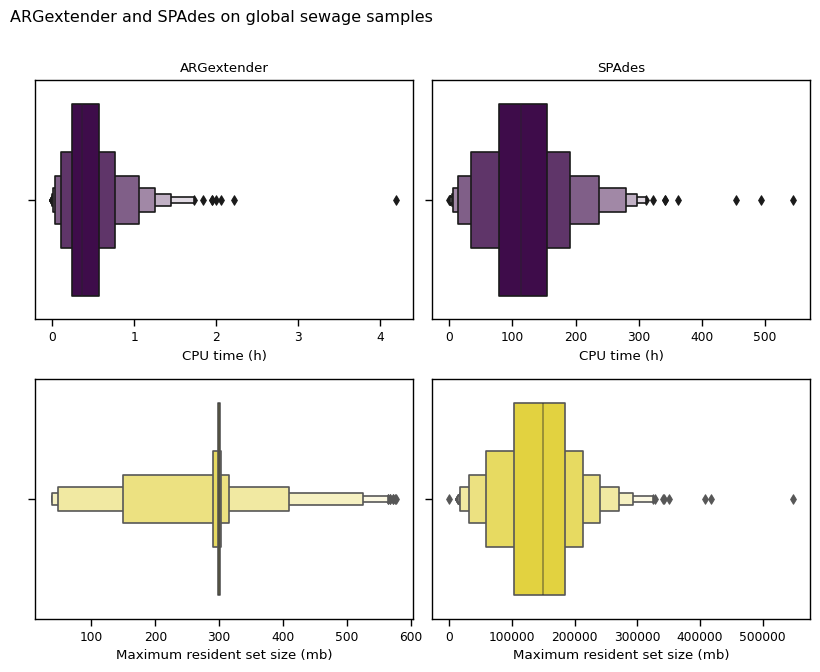

In [218]:
fig, axes = plt.subplots(ncols=2, nrows=2, gridspec_kw={'hspace': 0.25, 'wspace': 0.05}, figsize=(10,7))

for i, (r, rtitle) in enumerate(zip(['seed_extender', 'SPAdes'], ['ARGextender', 'SPAdes'])):
    d = gs2_compare.query(f"rule == '{r}'")
    for j, x in enumerate([x1, x2]):
        sns.boxenplot(
            data = d,
            x = x,
            color=Palette[x],
            ax = axes[j,i]
        )
        
        if j == 0:
            axes[j, i].set_xlabel('CPU time (h)')
        
        if j == 0:
            axes[j,i].set_title(rtitle)
fig.suptitle('ARGextender and SPAdes on global sewage samples', horizontalalignment='left', x=0.1)
figure_saver(fig=fig, prefix='figures/gs2_argextender_spades')

# Final rules and their computational requirements

## averages + std

In [219]:
dfs['final'].rule.unique()

array(['mash_sketch', 'kma_virulence', 'kma_mOTUs', 'trimmed_reads',
       'kma_panres', 'seed_extender'], dtype=object)

In [220]:
rule_order = ['raw_reads', 'trimmed_reads', 'kma_mOTUs','kma_panres',  'seed_extender', 'mash_sketch']
print(x1)
pd.concat([dfs['final'], dfs['zip'].query("rule == 'raw_reads'")]).query("sample in @samples29 & rule in @rule_order").groupby(['rule'])[x1].describe().round(2).loc[rule_order, ['mean', 'std']]

cpu_time_h


,mean,std
rule,,
raw_reads,0.03,0.06
trimmed_reads,0.53,1.23
kma_mOTUs,2.66,6.04
kma_panres,0.43,0.99
seed_extender,2.06,5.20
mash_sketch,0.24,0.59


In [221]:
print(x2)
pd.concat([dfs['final'], dfs['zip'].query("rule == 'raw_reads'")]).query("sample in @samples29 & rule in @rule_order").groupby(['rule'])[x2].describe().round(2).loc[rule_order, ['mean', 'std']]

Maximum resident set size (mb)


,mean,std
rule,,
raw_reads,30.76,0.13
trimmed_reads,2375.95,1748.43
kma_mOTUs,6817.09,3.44
kma_panres,308.75,137.05
seed_extender,539.61,804.92
mash_sketch,2.03,0.10


## total compared to read sizes

In [222]:
samples29_meta = pd.read_csv('data/29_samples_meta.csv', index_col=[0,1]).T

In [223]:
samples29_tot = pd.concat([dfs['final'], dfs['zip'].query("rule == 'raw_reads'")]).query("sample in @samples29 & rule in @rule_order").groupby(['sample'])[[x1, x2]].sum()

In [224]:
samples29_tot_meta = samples29_tot.merge(samples29_meta[['raw_bases']], left_index=True, right_index=True)
cols = [c for c in samples29_tot_meta.columns]
cols[-1] = cols[-1][0]
samples29_tot_meta.columns = cols 

samples29_tot_meta['raw_megabases'] = samples29_tot_meta['raw_bases'].astype(float) * 10**(-6)
samples29_tot_meta['raw_gigabases'] = samples29_tot_meta['raw_bases'].astype(float) * 10**(-9)

/var/folders/xn/wtz0b0kn1nlcb56q5mn_b8zw0000gp/T/ipykernel_14867/1436287116.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  samples29_tot_meta = samples29_tot.merge(samples29_meta[['raw_bases']], left_index=True, right_index=True)


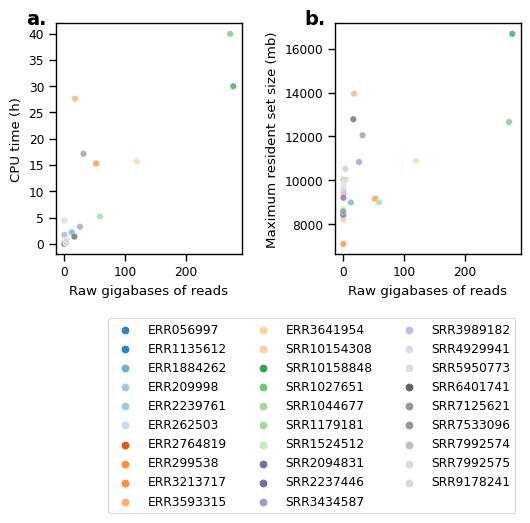

In [225]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(6,3), gridspec_kw={'wspace': .5})

sns.scatterplot(
    data = samples29_tot_meta.reset_index(),
    x = 'raw_gigabases',
    y = x1,
    ax = axes[0],
    hue = 'sample',
    palette = get_cmap(labels=samples29, name='tab20c'),
    alpha = .75
)
sns.scatterplot(
    data = samples29_tot_meta.reset_index(),
    x = 'raw_gigabases',
    y = x2,
    ax = axes[1],
    hue = 'sample',
    palette = get_cmap(labels=samples29, name='tab20c'),
    alpha = .75
)

axes[0].get_legend().remove()
axes[1].legend(loc='upper left', bbox_to_anchor=(-1.25,-.25), ncol=3)

for i, ax in enumerate(axes.flatten()):
    ax.set_xlabel('Raw gigabases of reads')
    ax.set_ylabel(collabels[ax.get_ylabel()])
    ax.text(-0.05, 1.06, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    
figure_saver(fig=fig, prefix='figures/raw_tots')

In [226]:
samples29_tot_meta[f"{x1}/gb"] = samples29_tot_meta[x1]/samples29_tot_meta['raw_gigabases']
print(f"average per gb bases:", samples29_tot_meta[f"{x1}/gb"].mean())
print(f"median per gb bases:", samples29_tot_meta[f"{x1}/gb"].median())

average per gb bases: 1.2069890846629867
median per gb bases: 0.36457490837177575


In [227]:
samples29_tot_meta[f"gb/{x1}"] = samples29_tot_meta[x1]/samples29_tot_meta['raw_gigabases']
print(f"average gb bases per {x1}:", samples29_tot_meta[f"gb/{x1}"].mean())
print(f"median gb bases per {x1}:", samples29_tot_meta[f"gb/{x1}"].median())

average gb bases per cpu_time_h: 1.2069890846629867
median gb bases per cpu_time_h: 0.36457490837177575
